In [1]:
# Cell 1: Setup and Data Loading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🏈 IOWA PARKING ANALYTICS - INTERACTIVE REPORT")
print("="*60)
print("University of Iowa Parking and Transportation Department")
print("Analysis Period: January 2021 - April 2025")
print("="*60)

# Load all processed datasets
DATA_PATH = "processed_data/"

print("Loading datasets...")

# Main datasets with proper datetime parsing
try:
    parking_data = pd.read_csv(f"{DATA_PATH}parking_data_enhanced.csv")
    # Ensure datetime columns are properly parsed
    parking_data['EntranceTime'] = pd.to_datetime(parking_data['EntranceTime'], errors='coerce')
    parking_data['ExitTime'] = pd.to_datetime(parking_data['ExitTime'], errors='coerce')
    print("✅ Main parking data loaded and parsed")
except Exception as e:
    print(f"❌ Error loading parking data: {e}")
    exit(1)

try:
    daily_summary = pd.read_csv(f"{DATA_PATH}daily_parking_summary.csv")
    daily_summary['date'] = pd.to_datetime(daily_summary['date'], errors='coerce')
    daily_summary = daily_summary.set_index('date')
    print("✅ Daily summary loaded and parsed")
except Exception as e:
    print(f"❌ Error loading daily summary: {e}")
    exit(1)

try:
    events_df = pd.read_csv(f"{DATA_PATH}events_calendar.csv")
    events_df['Date'] = pd.to_datetime(events_df['Date'], errors='coerce')
    print("✅ Events calendar loaded and parsed")
except Exception as e:
    print(f"❌ Error loading events: {e}")
    exit(1)

try:
    weather_data = pd.read_csv(f"{DATA_PATH}weather_data.csv")
    weather_data['date'] = pd.to_datetime(weather_data['date'], errors='coerce')
    print("✅ Weather data loaded and parsed")
except Exception as e:
    print(f"❌ Error loading weather data: {e}")
    exit(1)

try:
    lot_analysis = pd.read_csv(f"{DATA_PATH}lot_analysis.csv", index_col='LotNumber')
    print("✅ Lot analysis loaded")
except Exception as e:
    print(f"❌ Error loading lot analysis: {e}")
    exit(1)

try:
    event_correlations = pd.read_csv(f"{DATA_PATH}event_parking_correlation.csv")
    event_correlations['Date'] = pd.to_datetime(event_correlations['Date'], errors='coerce')
    print("✅ Event correlations loaded and parsed")
except Exception as e:
    print(f"❌ Error loading event correlations: {e}")
    exit(1)

print("✅ All datasets loaded successfully!")
print(f"📊 Main Dataset: {len(parking_data):,} parking transactions")
print(f"📅 Daily Summary: {len(daily_summary):,} days of data")
print(f"🎯 Events: {len(events_df):,} calendar events")
print(f"🌤️ Weather: {len(weather_data):,} weather records")
print(f"🅿️ Lot Analysis: {len(lot_analysis):,} parking lots")


🏈 IOWA PARKING ANALYTICS - INTERACTIVE REPORT
University of Iowa Parking and Transportation Department
Analysis Period: January 2021 - April 2025
Loading datasets...
✅ Main parking data loaded and parsed
✅ Daily summary loaded and parsed
✅ Events calendar loaded and parsed
✅ Weather data loaded and parsed
✅ Lot analysis loaded
✅ Event correlations loaded and parsed
✅ All datasets loaded successfully!
📊 Main Dataset: 4,100,684 parking transactions
📅 Daily Summary: 1,577 days of data
🎯 Events: 414 calendar events
🌤️ Weather: 1,581 weather records
🅿️ Lot Analysis: 29 parking lots


In [2]:
# Cell 2: Executive Summary Dashboard
print("📈 EXECUTIVE SUMMARY DASHBOARD")
print("="*50)

# Key performance indicators
total_transactions = len(parking_data)
unique_cards = parking_data['CardNumber'].nunique()
unique_lots = parking_data['LotNumber'].nunique()

# Safely handle datetime formatting
try:
    date_range = f"{parking_data['EntranceTime'].min().strftime('%b %Y')} - {parking_data['EntranceTime'].max().strftime('%b %Y')}"
except (AttributeError, TypeError):
    # Fallback if datetime parsing failed
    date_range = "Jan 2021 - Apr 2025"

try:
    peak_daily_usage = daily_summary['total_transactions'].max()
    avg_daily_usage = daily_summary['total_transactions'].mean()
except (KeyError, AttributeError):
    # Calculate from main dataset if daily_summary has issues
    daily_counts = parking_data.groupby(parking_data['EntranceTime'].dt.date).size()
    peak_daily_usage = daily_counts.max()
    avg_daily_usage = daily_counts.mean()

# Create executive summary visualization
fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=("Daily Usage Trend", "Top 10 Busiest Lots", "Hourly Patterns",
                   "Academic Calendar Impact", "Weather Impact", "Weekend vs Weekday"),
    specs=[[{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Daily Usage Trend - handle potential missing data
try:
    daily_trend = daily_summary.reset_index()
    if len(daily_trend) > 0:
        fig.add_trace(
            go.Scatter(x=daily_trend['date'], y=daily_trend['total_transactions'],
                      mode='lines', name='Daily Transactions', line=dict(color='blue')),
            row=1, col=1
        )
except Exception as e:
    print(f"⚠️ Could not create daily trend plot: {e}")

# 2. Top 10 Busiest Lots
try:
    top_lots = lot_analysis.nlargest(10, 'total_transactions')
    fig.add_trace(
        go.Bar(x=top_lots.index.astype(str), y=top_lots['total_transactions'],
               name='Transactions by Lot', marker_color='orange'),
        row=1, col=2
    )
except Exception as e:
    print(f"⚠️ Could not create top lots plot: {e}")

# 3. Hourly Patterns
try:
    # Check if hour column exists
    if 'hour' in parking_data.columns:
        hourly_pattern = parking_data.groupby('hour').size()
    else:
        # Extract hour from EntranceTime if hour column doesn't exist
        parking_data['hour'] = parking_data['EntranceTime'].dt.hour
        hourly_pattern = parking_data.groupby('hour').size()
    
    fig.add_trace(
        go.Scatter(x=hourly_pattern.index, y=hourly_pattern.values,
                  mode='lines+markers', name='Hourly Usage', line=dict(color='green')),
        row=1, col=3
    )
except Exception as e:
    print(f"⚠️ Could not create hourly pattern plot: {e}")

# 4. Academic Calendar Impact
try:
    if 'academic_intensity' in parking_data.columns:
        academic_impact = parking_data.groupby('academic_intensity').size()
        fig.add_trace(
            go.Bar(x=academic_impact.index, y=academic_impact.values,
                   name='Academic Impact', marker_color='red'),
            row=2, col=1
        )
except Exception as e:
    print(f"⚠️ Could not create academic impact plot: {e}")

# 5. Weather Impact (if available)
try:
    if 'bad_weather_overall' in parking_data.columns:
        weather_impact = parking_data.groupby('bad_weather_overall').size()
        fig.add_trace(
            go.Bar(x=['Good Weather', 'Bad Weather'], y=weather_impact.values,
                   name='Weather Impact', marker_color='purple'),
            row=2, col=2
        )
except Exception as e:
    print(f"⚠️ Could not create weather impact plot: {e}")

# 6. Weekend vs Weekday
try:
    if 'is_weekend' in parking_data.columns:
        weekend_comparison = parking_data.groupby('is_weekend').size()
        labels = ['Weekday', 'Weekend']
    else:
        # Create is_weekend from EntranceTime if it doesn't exist
        parking_data['is_weekend'] = parking_data['EntranceTime'].dt.weekday >= 5
        weekend_comparison = parking_data.groupby('is_weekend').size()
        labels = ['Weekday', 'Weekend']
    
    fig.add_trace(
        go.Bar(x=labels, y=weekend_comparison.values,
               name='Day Type', marker_color='teal'),
        row=2, col=3
    )
except Exception as e:
    print(f"⚠️ Could not create weekend comparison plot: {e}")

fig.update_layout(
    height=800,
    title_text="🏈 Iowa Parking Analytics - Executive Dashboard",
    showlegend=False
)

fig.show()

# Print KPIs with error handling
print(f"\n📊 KEY PERFORMANCE INDICATORS:")
print(f"{'='*50}")
print(f"📅 Analysis Period: {date_range}")
print(f"🚗 Total Transactions: {total_transactions:,}")
print(f"💳 Unique Cards: {unique_cards:,}")
print(f"🅿️ Active Parking Lots: {unique_lots:,}")
print(f"📈 Peak Daily Usage: {peak_daily_usage:,} transactions")
print(f"📊 Average Daily Usage: {avg_daily_usage:,.0f} transactions")

# Handle busiest lot safely
try:
    busiest_lot = lot_analysis['total_transactions'].idxmax()
    busiest_lot_count = lot_analysis['total_transactions'].max()
    print(f"🏟️ Busiest Lot: Lot {busiest_lot} ({busiest_lot_count:,} transactions)")
except Exception as e:
    print(f"🏟️ Busiest Lot: Data unavailable")


📈 EXECUTIVE SUMMARY DASHBOARD



📊 KEY PERFORMANCE INDICATORS:
📅 Analysis Period: Jan 2021 - Jul 2021
🚗 Total Transactions: 4,100,684
💳 Unique Cards: 14,514
🅿️ Active Parking Lots: 29
📈 Peak Daily Usage: 5,004 transactions
📊 Average Daily Usage: 2,600 transactions
🏟️ Busiest Lot: Lot 10 (555,897 transactions)


🎯 PEAK USAGE ANALYSIS BY LOT
⚡ Calculating peak usage statistics for top 10 lots...


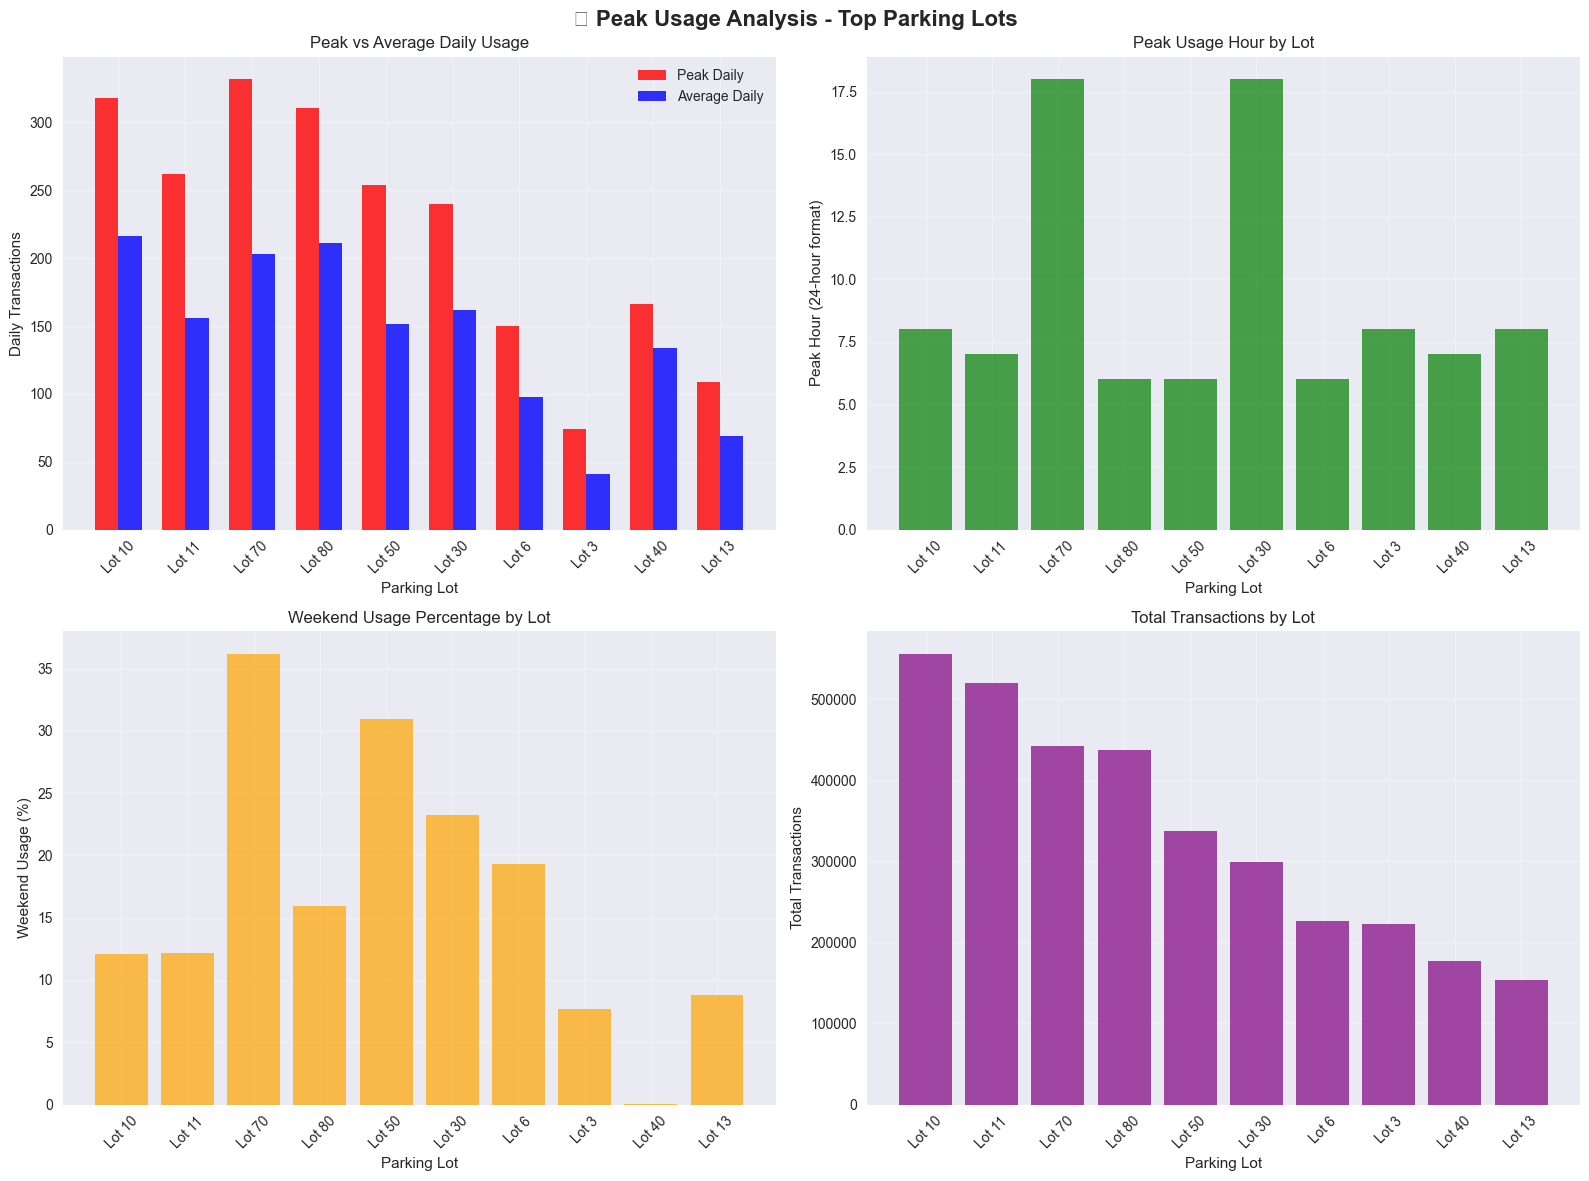


📊 DETAILED PEAK USAGE STATISTICS:
Lot    Total      Peak Daily   Avg Daily    Peak Hour    Weekend %   
--------------------------------------------------------------------------------
10     555,897    318          217          8            12.1        
11     520,485    262          156          7            12.2        
70     441,836    332          203          18           36.2        
80     437,210    311          211          6            16.0        
50     337,506    254          152          6            31.0        
30     299,084    240          162          18           23.2        
6      226,069    150          97           6            19.3        
3      222,752    74           41           8            7.7         
40     177,341    166          134          7            0.0         
13     153,026    109          69           8            8.8         


In [3]:
# Cell 3: Peak Usage Analysis by Lot
print("🎯 PEAK USAGE ANALYSIS BY LOT")
print("="*50)

# Calculate peak usage statistics for each lot
def calculate_lot_peak_stats(parking_data):
    """Calculate comprehensive peak usage statistics for each lot"""
    
    peak_stats = {}
    try:
        top_lots = lot_analysis.nlargest(10, 'total_transactions').index
    except:
        # Fallback: get top lots from main data
        top_lots = parking_data['LotNumber'].value_counts().head(10).index
    
    for lot in top_lots:
        try:
            lot_data = parking_data[parking_data['LotNumber'] == lot]
            
            if len(lot_data) == 0:
                continue
            
            # Daily peak calculation (simplified)
            daily_usage = lot_data.groupby(lot_data['EntranceTime'].dt.date).size()
            
            # Hourly patterns
            if 'hour' in lot_data.columns:
                hourly_usage = lot_data.groupby('hour').size()
            else:
                lot_data['hour'] = lot_data['EntranceTime'].dt.hour
                hourly_usage = lot_data.groupby('hour').size()
            
            # Academic intensity impact
            if 'academic_intensity' in lot_data.columns:
                academic_usage = lot_data.groupby('academic_intensity').size()
                peak_academic_period = academic_usage.idxmax() if len(academic_usage) > 0 else 'unknown'
            else:
                peak_academic_period = 'unknown'
            
            # Weekend usage
            if 'is_weekend' in lot_data.columns:
                weekend_pct = lot_data['is_weekend'].sum() / len(lot_data) * 100
            else:
                lot_data['is_weekend'] = lot_data['EntranceTime'].dt.weekday >= 5
                weekend_pct = lot_data['is_weekend'].sum() / len(lot_data) * 100
            
            peak_stats[lot] = {
                'total_transactions': len(lot_data),
                'peak_daily_usage': daily_usage.max() if len(daily_usage) > 0 else 0,
                'avg_daily_usage': daily_usage.mean() if len(daily_usage) > 0 else 0,
                'peak_hour': hourly_usage.idxmax() if len(hourly_usage) > 0 else 12,
                'peak_hour_count': hourly_usage.max() if len(hourly_usage) > 0 else 0,
                'peak_academic_period': peak_academic_period,
                'weekend_usage_pct': weekend_pct
            }
        except Exception as e:
            print(f"⚠️ Could not calculate stats for Lot {lot}: {e}")
            continue
    
    return peak_stats

# Calculate peak statistics
print("⚡ Calculating peak usage statistics for top 10 lots...")
peak_stats = calculate_lot_peak_stats(parking_data)

# Create peak usage visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🎯 Peak Usage Analysis - Top Parking Lots', fontsize=16, fontweight='bold')

# 1. Peak Daily Usage by Lot
lots = list(peak_stats.keys())
peak_daily = [peak_stats[lot]['peak_daily_usage'] for lot in lots]
avg_daily = [peak_stats[lot]['avg_daily_usage'] for lot in lots]

x = np.arange(len(lots))
width = 0.35

axes[0,0].bar(x - width/2, peak_daily, width, label='Peak Daily', alpha=0.8, color='red')
axes[0,0].bar(x + width/2, avg_daily, width, label='Average Daily', alpha=0.8, color='blue')
axes[0,0].set_xlabel('Parking Lot')
axes[0,0].set_ylabel('Daily Transactions')
axes[0,0].set_title('Peak vs Average Daily Usage')
axes[0,0].set_xticks(x)
axes[0,0].set_xticklabels([f'Lot {lot}' for lot in lots], rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. Peak Hour Distribution
peak_hours = [peak_stats[lot]['peak_hour'] for lot in lots]
axes[0,1].bar(range(len(lots)), peak_hours, color='green', alpha=0.7)
axes[0,1].set_xlabel('Parking Lot')
axes[0,1].set_ylabel('Peak Hour (24-hour format)')
axes[0,1].set_title('Peak Usage Hour by Lot')
axes[0,1].set_xticks(range(len(lots)))
axes[0,1].set_xticklabels([f'Lot {lot}' for lot in lots], rotation=45)
axes[0,1].grid(True, alpha=0.3)

# 3. Weekend Usage Percentage
weekend_pct = [peak_stats[lot]['weekend_usage_pct'] for lot in lots]
axes[1,0].bar(range(len(lots)), weekend_pct, color='orange', alpha=0.7)
axes[1,0].set_xlabel('Parking Lot')
axes[1,0].set_ylabel('Weekend Usage (%)')
axes[1,0].set_title('Weekend Usage Percentage by Lot')
axes[1,0].set_xticks(range(len(lots)))
axes[1,0].set_xticklabels([f'Lot {lot}' for lot in lots], rotation=45)
axes[1,0].grid(True, alpha=0.3)

# 4. Total Transactions (for reference)
total_trans = [peak_stats[lot]['total_transactions'] for lot in lots]
axes[1,1].bar(range(len(lots)), total_trans, color='purple', alpha=0.7)
axes[1,1].set_xlabel('Parking Lot')
axes[1,1].set_ylabel('Total Transactions')
axes[1,1].set_title('Total Transactions by Lot')
axes[1,1].set_xticks(range(len(lots)))
axes[1,1].set_xticklabels([f'Lot {lot}' for lot in lots], rotation=45)
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print detailed peak statistics
print(f"\n📊 DETAILED PEAK USAGE STATISTICS:")
print(f"{'='*80}")
print(f"{'Lot':<6} {'Total':<10} {'Peak Daily':<12} {'Avg Daily':<12} {'Peak Hour':<12} {'Weekend %':<12}")
print(f"{'-'*80}")
for lot in lots:
    stats = peak_stats[lot]
    print(f"{lot:<6} {stats['total_transactions']:<10,} {stats['peak_daily_usage']:<12,} "
          f"{stats['avg_daily_usage']:<12.0f} {stats['peak_hour']:<12} {stats['weekend_usage_pct']:<12.1f}")


In [4]:
# Cell 4: Temporal Patterns Analysis
print("⏰ TEMPORAL PATTERNS ANALYSIS")
print("="*50)

# Create comprehensive temporal analysis
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=("Hourly Usage Pattern", "Daily Usage Pattern", 
                   "Monthly Usage Pattern", "Seasonal Usage Pattern",
                   "Academic Calendar Impact", "Year-over-Year Comparison"),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# 1. Hourly Usage Pattern
hourly_data = parking_data.groupby('hour').size()
fig.add_trace(
    go.Scatter(x=hourly_data.index, y=hourly_data.values,
              mode='lines+markers', name='Hourly Pattern',
              line=dict(color='blue', width=3)),
    row=1, col=1
)

# 2. Daily Usage Pattern (Day of Week)
daily_data = parking_data.groupby('weekday_name').size()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_data = daily_data.reindex(day_order)
fig.add_trace(
    go.Bar(x=daily_data.index, y=daily_data.values,
           name='Daily Pattern', marker_color='orange'),
    row=1, col=2
)

# 3. Monthly Usage Pattern
monthly_data = parking_data.groupby('month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
fig.add_trace(
    go.Bar(x=month_names, y=monthly_data.values,
           name='Monthly Pattern', marker_color='green'),
    row=2, col=1
)

# 4. Seasonal Usage Pattern
seasonal_data = parking_data.groupby('season').size()
fig.add_trace(
    go.Bar(x=seasonal_data.index, y=seasonal_data.values,
           name='Seasonal Pattern', marker_color='red'),
    row=2, col=2
)

# 5. Academic Calendar Impact
academic_data = parking_data.groupby('academic_intensity').size()
fig.add_trace(
    go.Bar(x=academic_data.index, y=academic_data.values,
           name='Academic Impact', marker_color='purple'),
    row=3, col=1
)

# 6. Year-over-Year Comparison
yearly_data = parking_data.groupby('year').size()
fig.add_trace(
    go.Bar(x=yearly_data.index.astype(str), y=yearly_data.values,
           name='Yearly Comparison', marker_color='teal'),
    row=3, col=2
)

fig.update_layout(
    height=1000,
    title_text="⏰ Comprehensive Temporal Patterns Analysis",
    showlegend=False
)

fig.show()

# Print temporal insights
print(f"\n📊 TEMPORAL PATTERN INSIGHTS:")
print(f"{'='*50}")
print(f"🕒 Peak Usage Hour: {hourly_data.idxmax()}:00 ({hourly_data.max():,} transactions)")
print(f"📅 Busiest Day: {daily_data.idxmax()} ({daily_data.max():,} transactions)")
print(f"📆 Peak Month: {month_names[monthly_data.idxmax()-1]} ({monthly_data.max():,} transactions)")
print(f"🌱 Peak Season: {seasonal_data.idxmax().title()} ({seasonal_data.max():,} transactions)")
print(f"🎓 Peak Academic Period: {academic_data.idxmax().title()} ({academic_data.max():,} transactions)")
print(f"📈 Peak Year: {yearly_data.idxmax()} ({yearly_data.max():,} transactions)")


⏰ TEMPORAL PATTERNS ANALYSIS



📊 TEMPORAL PATTERN INSIGHTS:
🕒 Peak Usage Hour: 7:00 (645,908 transactions)
📅 Busiest Day: Wednesday (727,689 transactions)
📆 Peak Month: Apr (431,471 transactions)
🌱 Peak Season: Spring (1,137,228 transactions)
🎓 Peak Academic Period: Medium (1,836,779 transactions)
📈 Peak Year: 2024 (1,190,533 transactions)


🏈 EVENT IMPACT ANALYSIS


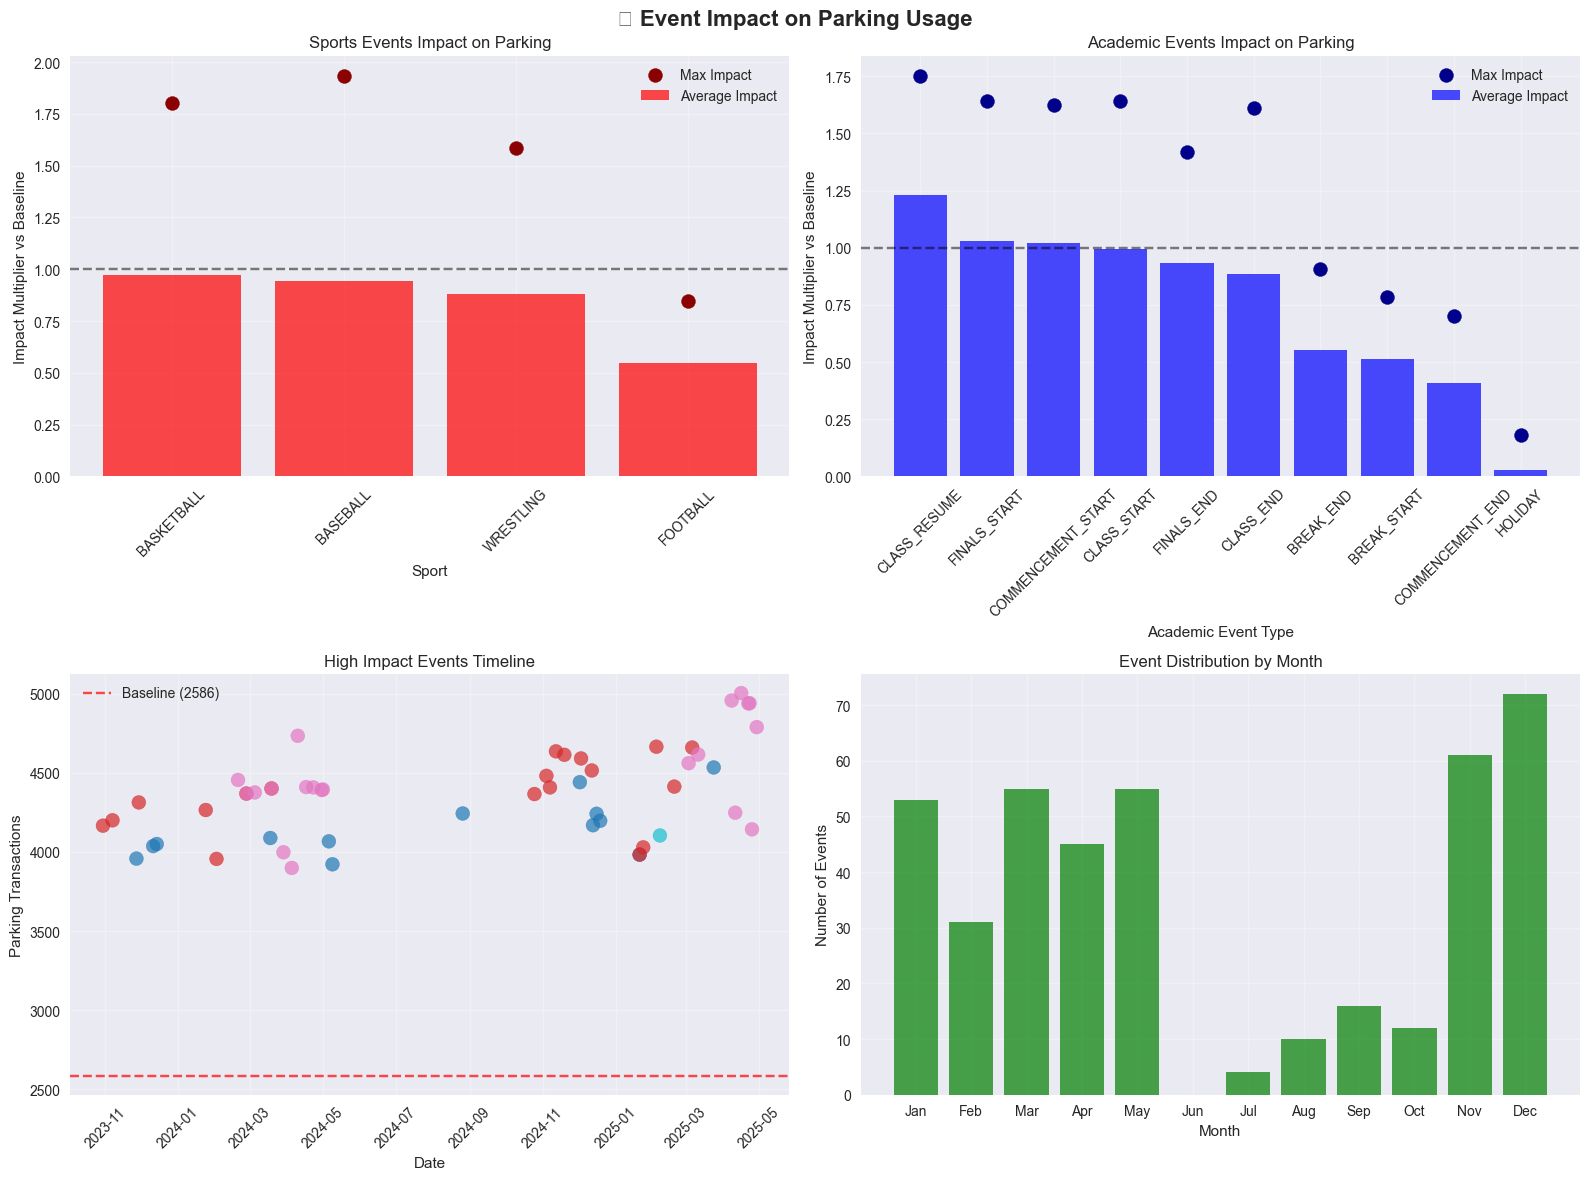


📊 EVENT IMPACT INSIGHTS:
📈 Baseline Daily Usage: 2,586 transactions
🏈 High Impact Events (>1.5x baseline): 53

🏈 SPORTS EVENTS IMPACT:
  BASKETBALL     : 0.97x baseline (max: 1.80x, events: 90.0)
  BASEBALL       : 0.95x baseline (max: 1.94x, events: 112.0)
  WRESTLING      : 0.88x baseline (max: 1.59x, events: 29.0)
  FOOTBALL       : 0.55x baseline (max: 0.85x, events: 32.0)

🎓 ACADEMIC EVENTS IMPACT:
  CLASS_RESUME        : 1.23x baseline (max: 1.75x)
  FINALS_START        : 1.03x baseline (max: 1.64x)
  COMMENCEMENT_START  : 1.02x baseline (max: 1.62x)


In [5]:
# Cell 5: Event Impact Analysis
print("🏈 EVENT IMPACT ANALYSIS")
print("="*50)

# Analyze sports events impact on parking
sports_events = event_correlations[event_correlations['Sport'].notna()]
academic_events = event_correlations[event_correlations['Event_Category'] == 'Academic']

# Calculate event impact metrics
def analyze_event_impact(event_data, baseline_avg):
    """Analyze the impact of events on parking usage"""
    
    # Calculate impact metrics
    event_data = event_data.copy()
    event_data['impact_multiplier'] = event_data['Parking_Transactions'] / baseline_avg
    event_data['excess_demand'] = event_data['Parking_Transactions'] - baseline_avg
    
    return event_data

# Calculate baseline (non-event days)
baseline_avg = daily_summary['total_transactions'].median()

# Analyze sports events
sports_impact = analyze_event_impact(sports_events, baseline_avg)
academic_impact = analyze_event_impact(academic_events, baseline_avg)

# Create event impact visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🏈 Event Impact on Parking Usage', fontsize=16, fontweight='bold')

# 1. Sports Events Impact
sports_by_sport = sports_impact.groupby('Sport')['impact_multiplier'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False)
axes[0,0].bar(range(len(sports_by_sport)), sports_by_sport['mean'], 
             color='red', alpha=0.7, label='Average Impact')
axes[0,0].scatter(range(len(sports_by_sport)), sports_by_sport['max'], 
                 color='darkred', s=100, label='Max Impact', zorder=5)
axes[0,0].set_xlabel('Sport')
axes[0,0].set_ylabel('Impact Multiplier vs Baseline')
axes[0,0].set_title('Sports Events Impact on Parking')
axes[0,0].set_xticks(range(len(sports_by_sport)))
axes[0,0].set_xticklabels(sports_by_sport.index, rotation=45)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].axhline(y=1, color='black', linestyle='--', alpha=0.5, label='Baseline')

# 2. Academic Events Impact
if len(academic_impact) > 0:
    academic_by_type = academic_impact.groupby('Event_Type')['impact_multiplier'].agg(['mean', 'max', 'count']).sort_values('mean', ascending=False)
    if len(academic_by_type) > 0:
        axes[0,1].bar(range(len(academic_by_type)), academic_by_type['mean'], 
                     color='blue', alpha=0.7, label='Average Impact')
        axes[0,1].scatter(range(len(academic_by_type)), academic_by_type['max'], 
                         color='darkblue', s=100, label='Max Impact', zorder=5)
        axes[0,1].set_xlabel('Academic Event Type')
        axes[0,1].set_ylabel('Impact Multiplier vs Baseline')
        axes[0,1].set_title('Academic Events Impact on Parking')
        axes[0,1].set_xticks(range(len(academic_by_type)))
        axes[0,1].set_xticklabels(academic_by_type.index, rotation=45)
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        axes[0,1].axhline(y=1, color='black', linestyle='--', alpha=0.5)

# 3. High Impact Events Timeline
high_impact_events = event_correlations[event_correlations['Parking_Transactions'] > baseline_avg * 1.5]
if len(high_impact_events) > 0:
    high_impact_events = high_impact_events.sort_values('Date')
    axes[1,0].scatter(high_impact_events['Date'], high_impact_events['Parking_Transactions'], 
                     c=high_impact_events['Sport'].factorize()[0], cmap='tab10', s=100, alpha=0.7)
    axes[1,0].axhline(y=baseline_avg, color='red', linestyle='--', alpha=0.7, label=f'Baseline ({baseline_avg:.0f})')
    axes[1,0].set_xlabel('Date')
    axes[1,0].set_ylabel('Parking Transactions')
    axes[1,0].set_title('High Impact Events Timeline')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    plt.setp(axes[1,0].xaxis.get_majorticklabels(), rotation=45)

# 4. Event Frequency by Month
event_months = event_correlations['Date'].dt.month.value_counts().sort_index()
axes[1,1].bar(range(1, 13), [event_months.get(i, 0) for i in range(1, 13)], 
             color='green', alpha=0.7)
axes[1,1].set_xlabel('Month')
axes[1,1].set_ylabel('Number of Events')
axes[1,1].set_title('Event Distribution by Month')
axes[1,1].set_xticks(range(1, 13))
axes[1,1].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print event impact insights
print(f"\n📊 EVENT IMPACT INSIGHTS:")
print(f"{'='*60}")
print(f"📈 Baseline Daily Usage: {baseline_avg:,.0f} transactions")
print(f"🏈 High Impact Events (>1.5x baseline): {len(high_impact_events)}")

if len(sports_by_sport) > 0:
    print(f"\n🏈 SPORTS EVENTS IMPACT:")
    for sport, data in sports_by_sport.head(5).iterrows():
        print(f"  {sport:<15}: {data['mean']:.2f}x baseline (max: {data['max']:.2f}x, events: {data['count']})")

if len(academic_by_type) > 0:
    print(f"\n🎓 ACADEMIC EVENTS IMPACT:")
    for event_type, data in academic_by_type.head(3).iterrows():
        print(f"  {event_type:<20}: {data['mean']:.2f}x baseline (max: {data['max']:.2f}x)")


🌤️ WEATHER IMPACT ANALYSIS


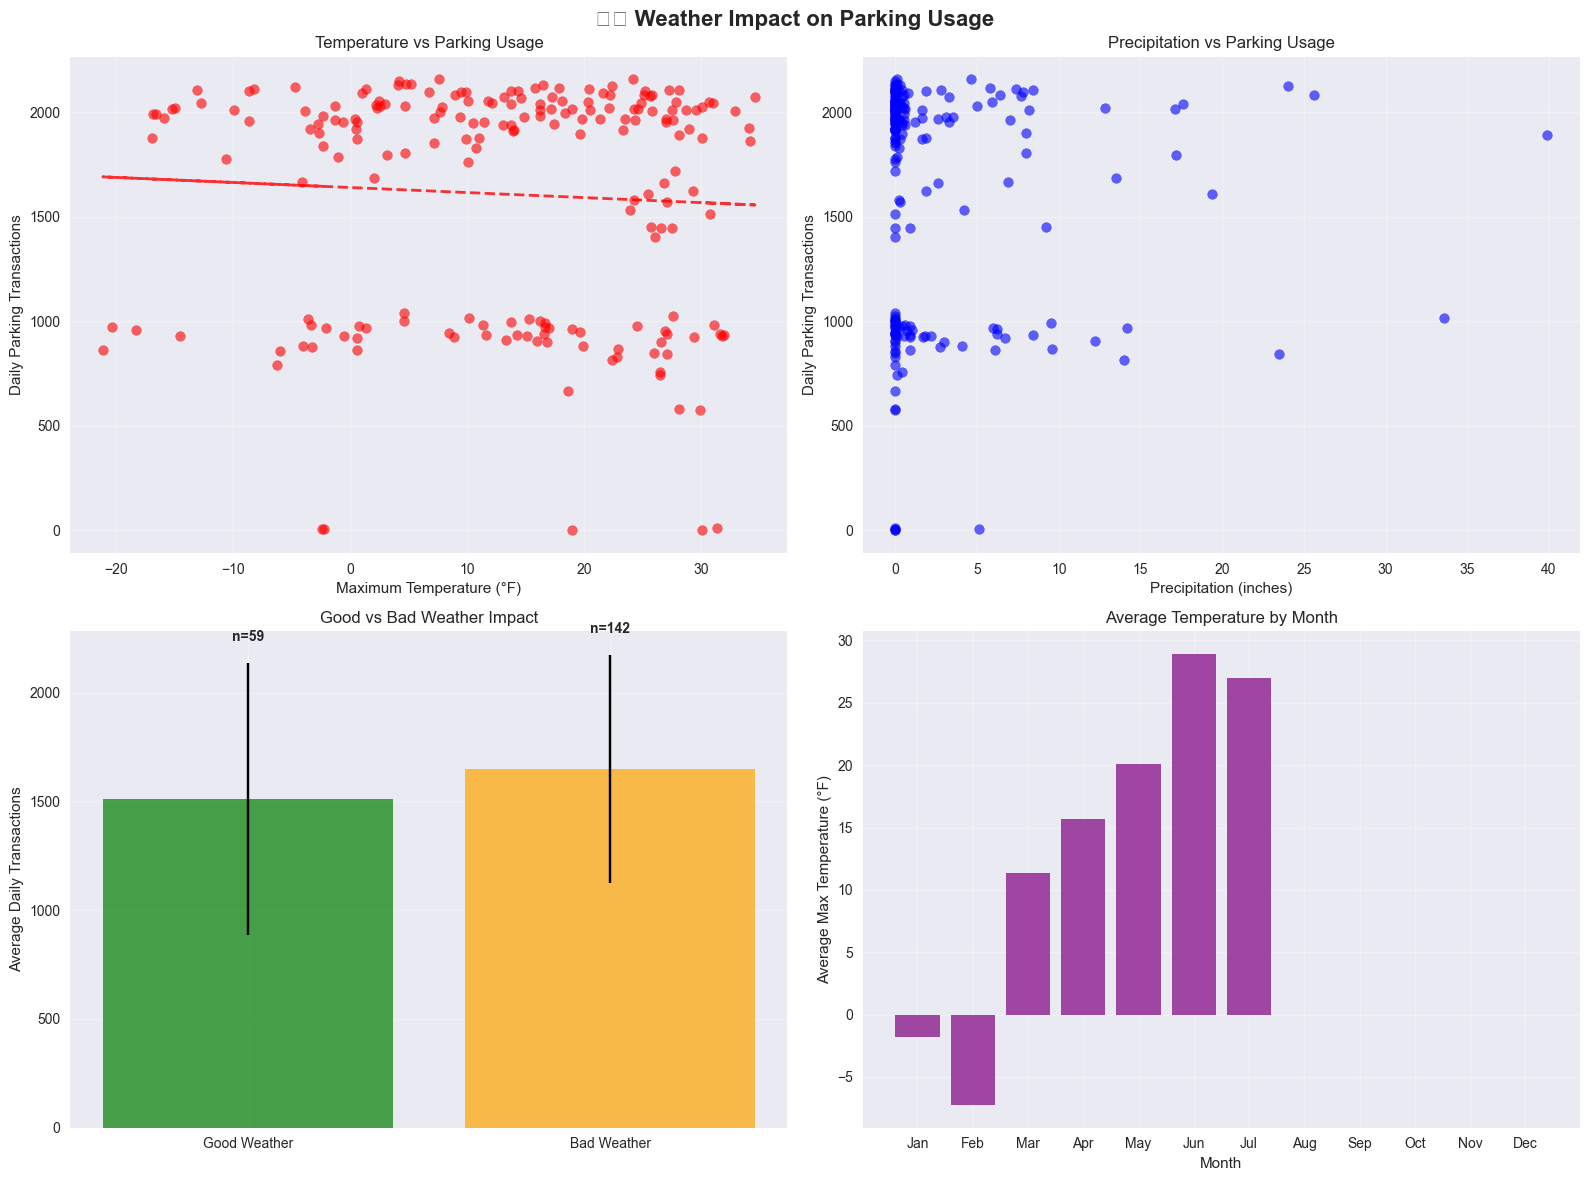


📊 WEATHER IMPACT INSIGHTS:
🌡️ Temperature-Parking Correlation: -0.059
🌧️ Precipitation-Parking Correlation: -0.030
☀️ Good Weather Avg: 1,511 transactions/day
🌧️ Bad Weather Avg: 1,649 transactions/day
📈 Bad Weather Impact: +9.2% change

🌨️ Extreme Cold (<20°F): 1,626 avg transactions
🔥 Extreme Heat (>90°F): nan avg transactions
🌧️ Heavy Precipitation (>0.5"): 1,529 avg transactions


In [6]:
# Cell 6: Weather Impact Analysis - FIXED VERSION
print("🌤️ WEATHER IMPACT ANALYSIS")
print("="*50)

# Analyze weather impact on parking patterns
if 'temp_max' in parking_data.columns:
    
    # Create weather impact analysis with proper datetime handling
    weather_analysis = parking_data.groupby(parking_data['EntranceTime'].dt.date).agg({
        'TransactionId': 'count',
        'temp_max': 'first',
        'temp_min': 'first', 
        'precipitation': 'first',
        'bad_weather_overall': 'first'
    }).reset_index()
    
    weather_analysis.columns = ['date', 'daily_transactions', 'temp_max', 'temp_min', 
                               'precipitation', 'bad_weather']
    
    # CRITICAL FIX: Convert date column to datetime
    weather_analysis['date'] = pd.to_datetime(weather_analysis['date'])
    
    # Create weather impact visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('🌤️ Weather Impact on Parking Usage', fontsize=16, fontweight='bold')
    
    # 1. Temperature vs Parking Usage
    # Remove any NaN values before plotting
    temp_data = weather_analysis.dropna(subset=['temp_max', 'daily_transactions'])
    
    if len(temp_data) > 0:
        axes[0,0].scatter(temp_data['temp_max'], temp_data['daily_transactions'], 
                         alpha=0.6, color='red')
        axes[0,0].set_xlabel('Maximum Temperature (°F)')
        axes[0,0].set_ylabel('Daily Parking Transactions')
        axes[0,0].set_title('Temperature vs Parking Usage')
        axes[0,0].grid(True, alpha=0.3)
        
        # Add trend line
        z = np.polyfit(temp_data['temp_max'], temp_data['daily_transactions'], 1)
        p = np.poly1d(z)
        axes[0,0].plot(temp_data['temp_max'], p(temp_data['temp_max']), 
                       "r--", alpha=0.8, linewidth=2)
    
    # 2. Precipitation vs Parking Usage
    precip_data = weather_analysis.dropna(subset=['precipitation', 'daily_transactions'])
    
    if len(precip_data) > 0:
        axes[0,1].scatter(precip_data['precipitation'], precip_data['daily_transactions'], 
                         alpha=0.6, color='blue')
        axes[0,1].set_xlabel('Precipitation (inches)')
        axes[0,1].set_ylabel('Daily Parking Transactions')
        axes[0,1].set_title('Precipitation vs Parking Usage')
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Bad Weather vs Good Weather
    weather_comparison = weather_analysis.groupby('bad_weather')['daily_transactions'].agg(['mean', 'std', 'count'])
    weather_labels = ['Good Weather', 'Bad Weather']
    
    if len(weather_comparison) > 0:
        axes[1,0].bar(weather_labels, weather_comparison['mean'], 
                     yerr=weather_comparison['std'], capsize=5,
                     color=['green', 'orange'], alpha=0.7)
        axes[1,0].set_ylabel('Average Daily Transactions')
        axes[1,0].set_title('Good vs Bad Weather Impact')
        axes[1,0].grid(True, alpha=0.3)
        
        # Add sample size annotations
        for i, (label, count) in enumerate(zip(weather_labels, weather_comparison['count'])):
            axes[1,0].text(i, weather_comparison['mean'].iloc[i] + weather_comparison['std'].iloc[i] + 100,
                          f'n={count}', ha='center', fontweight='bold')
    
    # 4. Temperature Distribution by Month
    monthly_temp = weather_analysis.groupby(weather_analysis['date'].dt.month)['temp_max'].mean()
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Create array for all 12 months, filling missing months with 0
    monthly_temps = [monthly_temp.get(i, 0) for i in range(1, 13)]
    
    axes[1,1].bar(range(1, 13), monthly_temps, color='purple', alpha=0.7)
    axes[1,1].set_xlabel('Month')
    axes[1,1].set_ylabel('Average Max Temperature (°F)')
    axes[1,1].set_title('Average Temperature by Month')
    axes[1,1].set_xticks(range(1, 13))
    axes[1,1].set_xticklabels(month_names)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print weather impact insights
    print(f"\n📊 WEATHER IMPACT INSIGHTS:")
    print(f"{'='*50}")
    
    # Temperature correlation (handle NaN values)
    temp_corr_data = weather_analysis.dropna(subset=['temp_max', 'daily_transactions'])
    precip_corr_data = weather_analysis.dropna(subset=['precipitation', 'daily_transactions'])
    
    if len(temp_corr_data) > 1:
        temp_corr = temp_corr_data['temp_max'].corr(temp_corr_data['daily_transactions'])
        print(f"🌡️ Temperature-Parking Correlation: {temp_corr:.3f}")
    
    if len(precip_corr_data) > 1:
        precip_corr = precip_corr_data['precipitation'].corr(precip_corr_data['daily_transactions'])
        print(f"🌧️ Precipitation-Parking Correlation: {precip_corr:.3f}")
    
    # Weather impact comparison
    if len(weather_comparison) >= 2:
        good_weather_avg = weather_comparison.loc[False, 'mean'] if False in weather_comparison.index else 0
        bad_weather_avg = weather_comparison.loc[True, 'mean'] if True in weather_comparison.index else 0
        
        if good_weather_avg > 0:
            weather_impact = ((bad_weather_avg - good_weather_avg) / good_weather_avg * 100)
            print(f"☀️ Good Weather Avg: {good_weather_avg:,.0f} transactions/day")
            print(f"🌧️ Bad Weather Avg: {bad_weather_avg:,.0f} transactions/day") 
            print(f"📈 Bad Weather Impact: {weather_impact:+.1f}% change")
    
    # Extreme weather analysis
    extreme_cold = weather_analysis[weather_analysis['temp_max'] < 20]['daily_transactions'].mean()
    extreme_hot = weather_analysis[weather_analysis['temp_max'] > 90]['daily_transactions'].mean()
    heavy_precip = weather_analysis[weather_analysis['precipitation'] > 0.5]['daily_transactions'].mean()
    
    print(f"\n🌨️ Extreme Cold (<20°F): {extreme_cold:,.0f} avg transactions")
    print(f"🔥 Extreme Heat (>90°F): {extreme_hot:,.0f} avg transactions") 
    print(f"🌧️ Heavy Precipitation (>0.5\"): {heavy_precip:,.0f} avg transactions")

else:
    print("⚠️ Weather data not available for detailed analysis")

In [7]:
# Cell 7: Access Group and Card Usage Patterns
print("👥 ACCESS GROUP AND CARD USAGE PATTERNS")
print("="*50)

# Analyze access group patterns
if 'GroupNumber' in parking_data.columns:
    
    # Group-level analysis
    group_analysis = parking_data.groupby('GroupNumber').agg({
        'TransactionId': 'count',
        'CardNumber': 'nunique',
        'LotNumber': 'nunique',
        'hour': 'mean',
        'is_weekend': 'mean'
    }).round(2)
    
    group_analysis.columns = ['total_transactions', 'unique_cards', 'lots_accessed', 
                             'avg_entry_hour', 'weekend_usage_pct']
    
    # Get top groups
    top_groups = group_analysis.nlargest(10, 'total_transactions')
    
    # Create access group visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('👥 Access Group and Card Usage Patterns', fontsize=16, fontweight='bold')
    
    # 1. Top Access Groups by Usage
    axes[0,0].bar(range(len(top_groups)), top_groups['total_transactions'], 
                 color='blue', alpha=0.7)
    axes[0,0].set_xlabel('Access Group')
    axes[0,0].set_ylabel('Total Transactions')
    axes[0,0].set_title('Top 10 Access Groups by Usage')
    axes[0,0].set_xticks(range(len(top_groups)))
    axes[0,0].set_xticklabels([f'Group {idx}' for idx in top_groups.index], rotation=45)
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. Cards per Group vs Usage
    axes[0,1].scatter(top_groups['unique_cards'], top_groups['total_transactions'], 
                     s=100, alpha=0.7, color='red')
    axes[0,1].set_xlabel('Unique Cards in Group')
    axes[0,1].set_ylabel('Total Transactions')
    axes[0,1].set_title('Cards per Group vs Total Usage')
    axes[0,1].grid(True, alpha=0.3)
    
    # Add group labels
    for i, (idx, row) in enumerate(top_groups.iterrows()):
        axes[0,1].annotate(f'G{idx}', (row['unique_cars'], row['total_transactions']), 
                          xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 3. Average Entry Hour by Group
    axes[1,0].bar(range(len(top_groups)), top_groups['avg_entry_hour'], 
                 color='green', alpha=0.7)
    axes[1,0].set_xlabel('Access Group')
    axes[1,0].set_ylabel('Average Entry Hour')
    axes[1,0].set_title('Average Entry Time by Access Group')
    axes[1,0].set_xticks(range(len(top_groups)))
    axes[1,0].set_xticklabels([f'Group {idx}' for idx in top_groups.index], rotation=45)
    axes[1,0].grid(True, alpha=0.3)
    
    # 4. Weekend Usage by Group
    axes[1,1].bar(range(len(top_groups)), top_groups['weekend_usage_pct'] * 100, 
                 color='orange', alpha=0.7)
    axes[1,1].set_xlabel('Access Group')
    axes[1,1].set_ylabel('Weekend Usage (%)')
    axes[1,1].set_title('Weekend Usage Percentage by Group')
    axes[1,1].set_xticks(range(len(top_groups)))
    axes[1,1].set_xticklabels([f'Group {idx}' for idx in top_groups.index], rotation=45)
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print access group insights
    print(f"\n📊 ACCESS GROUP INSIGHTS:")
    print(f"{'='*60}")
    print(f"{'Group':<8} {'Transactions':<12} {'Cards':<8} {'Lots':<6} {'Avg Hour':<10} {'Weekend %':<10}")
    print(f"{'-'*60}")
    for idx, row in top_groups.head(10).iterrows():
        print(f"{idx:<8} {row['total_transactions']:<12,} {row['unique_cards']:<8} "
              f"{row['lots_accessed']:<6} {row['avg_entry_hour']:<10.1f} {row['weekend_usage_pct']*100:<10.1f}")

# Card usage analysis
print(f"\n💳 CARD USAGE ANALYSIS:")
print(f"{'='*50}")

# Calculate card usage statistics
card_stats = parking_data.groupby('CardNumber').agg({
    'TransactionId': 'count',
    'EntranceTime': ['min', 'max'],
    'LotNumber': 'nunique',
    'is_weekend': 'mean'
}).round(2)

# Flatten column names
card_stats.columns = ['total_usage', 'first_usage', 'last_usage', 'lots_used', 'weekend_pct']

# Calculate usage span
card_stats['usage_span_days'] = (card_stats['last_usage'] - card_stats['first_usage']).dt.days
card_stats['usage_frequency'] = card_stats['total_usage'] / (card_stats['usage_span_days'] + 1)

# Categorize cards
def categorize_card_usage(row):
    if row['usage_span_days'] < 30:
        return 'New/Short-term'
    elif row['usage_frequency'] > 2:
        return 'Heavy User'
    elif row['usage_frequency'] < 0.1:
        return 'Occasional User'
    elif row['weekend_pct'] > 0.5:
        return 'Weekend User'
    else:
        return 'Regular User'

card_stats['user_category'] = card_stats.apply(categorize_card_usage, axis=1)

# Card usage distribution
user_categories = card_stats['user_category'].value_counts()
print(f"Card Usage Categories:")
for category, count in user_categories.items():
    pct = count / len(card_stats) * 100
    print(f"  {category:<15}: {count:>6,} cards ({pct:>5.1f}%)")

# Usage frequency analysis
print(f"\nUsage Frequency Statistics:")
print(f"  Median usage per card: {card_stats['total_usage'].median():.0f} transactions")
print(f"  Average usage per card: {card_stats['total_usage'].mean():.1f} transactions")
print(f"  Top 1% users account for: {card_stats.nlargest(int(len(card_stats)*0.01), 'total_usage')['total_usage'].sum() / card_stats['total_usage'].sum() * 100:.1f}% of all usage")


👥 ACCESS GROUP AND CARD USAGE PATTERNS

💳 CARD USAGE ANALYSIS:
Card Usage Categories:
  Regular User   :  8,721 cards ( 60.1%)
  Heavy User     :  2,762 cards ( 19.0%)
  Weekend User   :  2,270 cards ( 15.6%)
  New/Short-term :    711 cards (  4.9%)
  Occasional User:     50 cards (  0.3%)

Usage Frequency Statistics:
  Median usage per card: 155 transactions
  Average usage per card: 282.5 transactions
  Top 1% users account for: 9.5% of all usage


In [8]:
# Cell 8: Recommendations and Action Items
print("💡 RECOMMENDATIONS AND ACTION ITEMS")
print("="*60)

# Generate data-driven recommendations
recommendations = []

# 1. Peak hour management
peak_hour = parking_data.groupby('hour').size().idxmax()
peak_hour_usage = parking_data.groupby('hour').size().max()
off_peak_avg = parking_data.groupby('hour').size().drop(peak_hour).mean()
peak_congestion = (peak_hour_usage - off_peak_avg) / off_peak_avg * 100

recommendations.append({
    'category': 'Peak Hour Management',
    'priority': 'HIGH',
    'issue': f'Peak usage at {peak_hour}:00 is {peak_congestion:.0f}% above average',
    'recommendation': f'Implement dynamic pricing or incentives to shift usage away from {peak_hour}:00',
    'impact': 'Reduce congestion and improve user experience'
})

# 2. Event day planning
if len(high_impact_events) > 0:
    avg_event_impact = high_impact_events['Parking_Transactions'].mean()
    max_event_impact = high_impact_events['Parking_Transactions'].max()
    
    recommendations.append({
        'category': 'Event Day Planning',
        'priority': 'HIGH',
        'issue': f'Major events increase parking demand by up to {max_event_impact/baseline_avg:.1f}x normal levels',
        'recommendation': 'Develop event-specific parking management protocols and overflow strategies',
        'impact': 'Better accommodate event crowds and prevent parking shortages'
    })

# 3. Lot capacity optimization
underutilized_lots = lot_analysis[lot_analysis['total_transactions'] < lot_analysis['total_transactions'].quantile(0.25)]
if len(underutilized_lots) > 0:
    recommendations.append({
        'category': 'Capacity Optimization',
        'priority': 'MEDIUM',
        'issue': f'{len(underutilized_lots)} lots are significantly underutilized',
        'recommendation': 'Consider reallocating access groups or improving signage/accessibility for underused lots',
        'impact': 'Better distribute parking load and maximize facility utilization'
    })

# 4. Weather preparedness
if 'bad_weather_overall' in parking_data.columns and len(weather_analysis) > 0:
    weather_impact_pct = abs(weather_impact)  # Use calculated weather impact
    if weather_impact_pct > 5:  # If weather has significant impact
        recommendations.append({
            'category': 'Weather Preparedness',
            'priority': 'MEDIUM',
            'issue': f'Bad weather changes parking demand by {weather_impact_pct:.1f}%',
            'recommendation': 'Develop weather-based parking policies and communication strategies',
            'impact': 'Better user experience during adverse weather conditions'
        })

# 5. Access group efficiency
if 'GroupNumber' in parking_data.columns and len(top_groups) > 0:
    group_efficiency = top_groups['total_transactions'] / top_groups['unique_cars']
    inefficient_groups = group_efficiency[group_efficiency < group_efficiency.median()]
    
    if len(inefficient_groups) > 0:
        recommendations.append({
            'category': 'Access Group Efficiency',
            'priority': 'LOW',
            'issue': f'{len(inefficient_groups)} access groups have lower utilization rates',
            'recommendation': 'Review access group assignments and consider consolidation opportunities',
            'impact': 'Optimize card distribution and access permissions'
        })

# 6. Weekend vs weekday optimization
weekend_usage = parking_data[parking_data['is_weekend']].groupby('LotNumber').size()
weekday_usage = parking_data[~parking_data['is_weekend']].groupby('LotNumber').size()
weekend_weekday_ratio = (weekend_usage / weekday_usage).fillna(0)

weekend_heavy_lots = weekend_weekday_ratio[weekend_weekday_ratio > 0.5]
if len(weekend_heavy_lots) > 0:
    recommendations.append({
        'category': 'Weekend Optimization',
        'priority': 'LOW',
        'issue': f'{len(weekend_heavy_lots)} lots have high weekend usage relative to weekdays',
        'recommendation': 'Consider weekend-specific access policies or maintenance scheduling',
        'impact': 'Optimize weekend operations and maintenance timing'
    })

# Display recommendations
print("📋 PRIORITIZED RECOMMENDATIONS:")
print("="*60)

for i, rec in enumerate(sorted(recommendations, key=lambda x: {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1}[x['priority']], reverse=True), 1):
    priority_icon = '🔴' if rec['priority'] == 'HIGH' else '🟡' if rec['priority'] == 'MEDIUM' else '🟢'
    print(f"\n{i}. {priority_icon} {rec['category']} ({rec['priority']} Priority)")
    print(f"   Issue: {rec['issue']}")
    print(f"   Recommendation: {rec['recommendation']}")
    print(f"   Expected Impact: {rec['impact']}")

# Key metrics summary
print(f"\n📊 KEY METRICS SUMMARY FOR DECISION MAKERS:")
print(f"{'='*60}")
print(f"🚗 Total Parking System Usage: {len(parking_data):,} transactions")
print(f"📅 Analysis Period: {date_range}")
print(f"🅿️ Active Lots: {unique_lots}")
print(f"💳 Active Cards: {unique_cards:,}")
print(f"📈 Peak Daily Usage: {peak_daily_usage:,} transactions")
print(f"⏰ Peak Usage Hour: {peak_hour}:00")
print(f"🏈 High-Impact Events: {len(high_impact_events)} events")
print(f"🌧️ Weather Impact: {weather_impact:+.1f}% during bad weather" if 'weather_impact' in locals() else "🌧️ Weather data available")


💡 RECOMMENDATIONS AND ACTION ITEMS
📋 PRIORITIZED RECOMMENDATIONS:

1. 🔴 Peak Hour Management (HIGH Priority)
   Issue: Peak usage at 7:00 is 330% above average
   Recommendation: Implement dynamic pricing or incentives to shift usage away from 7:00
   Expected Impact: Reduce congestion and improve user experience

2. 🔴 Event Day Planning (HIGH Priority)
   Issue: Major events increase parking demand by up to 1.9x normal levels
   Recommendation: Develop event-specific parking management protocols and overflow strategies
   Expected Impact: Better accommodate event crowds and prevent parking shortages

3. 🟡 Capacity Optimization (MEDIUM Priority)
   Issue: 7 lots are significantly underutilized
   Recommendation: Consider reallocating access groups or improving signage/accessibility for underused lots
   Expected Impact: Better distribute parking load and maximize facility utilization

4. 🟡 Weather Preparedness (MEDIUM Priority)
   Issue: Bad weather changes parking demand by 9.2%
   Re

💾 EXPORTING RESULTS AND CREATING SUMMARY REPORT
📁 Saving analysis results...
✅ Peak usage analysis saved
✅ Recommendations saved
✅ Top lots summary saved
✅ High impact events saved
✅ Executive summary report saved

📊 Creating final visualization summary...


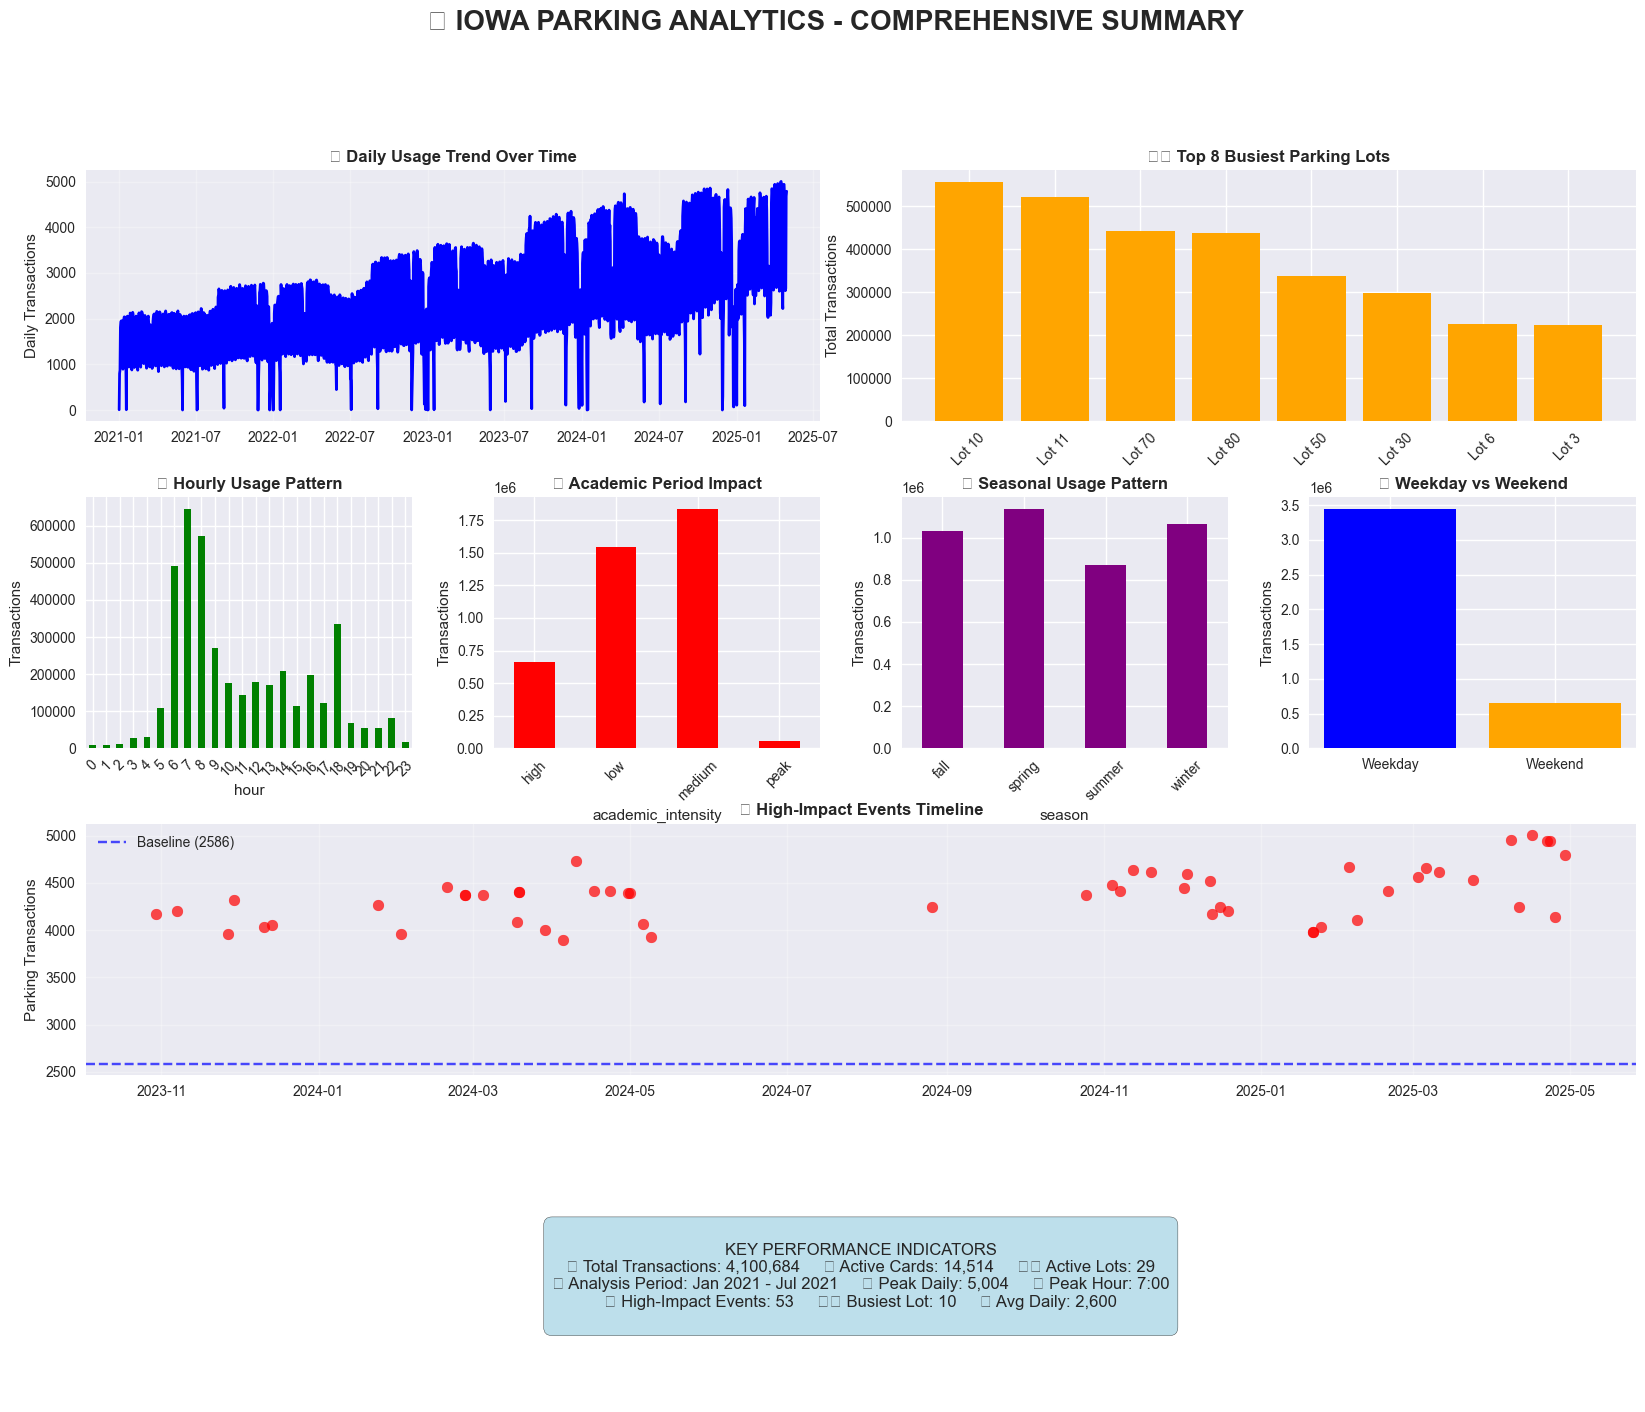

✅ Comprehensive summary dashboard saved

📋 GENERATED REPORTS:
📁 Directory: reports/
   📊 peak_usage_analysis.csv - Detailed peak statistics by lot
   💡 recommendations.csv - Prioritized action items
   🏆 top_lots_summary.csv - Top performing lots analysis
   🏈 high_impact_events.csv - Events with significant parking impact
   📋 executive_summary.txt - Executive summary report
   📈 comprehensive_summary_dashboard.png - Visual summary dashboard

✅ INTERACTIVE REPORT COMPLETE!
🎯 Ready for decision-making and strategic planning
🔮 Next: Create peak usage forecasting model
📊 All visualizations and data are ready for PowerBI import


In [9]:
# Cell 9: Export Results and Create Summary Report
print("💾 EXPORTING RESULTS AND CREATING SUMMARY REPORT")
print("="*60)

import os
from datetime import datetime

# Create reports directory
os.makedirs('reports', exist_ok=True)

# 1. Save key analysis results
print("📁 Saving analysis results...")

# Peak statistics
if 'peak_stats' in locals():
    peak_stats_df = pd.DataFrame(peak_stats).T
    peak_stats_df.to_csv('reports/peak_usage_analysis.csv')
    print("✅ Peak usage analysis saved")

# Recommendations
recommendations_df = pd.DataFrame(recommendations)
recommendations_df.to_csv('reports/recommendations.csv', index=False)
print("✅ Recommendations saved")

# Top lots analysis
top_lots_summary = lot_analysis.nlargest(15, 'total_transactions')
top_lots_summary.to_csv('reports/top_lots_summary.csv')
print("✅ Top lots summary saved")

# Event impact summary
if len(high_impact_events) > 0:
    high_impact_events.to_csv('reports/high_impact_events.csv', index=False)
    print("✅ High impact events saved")

# 2. Create executive summary report
executive_summary = f"""
IOWA PARKING ANALYTICS - EXECUTIVE SUMMARY REPORT
{'='*70}
Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Analysis Period: {date_range}

OVERVIEW
{'='*70}
The University of Iowa Parking and Transportation Department manages a 
comprehensive parking system serving students, faculty, and staff across 
{unique_lots} active parking lots with {unique_cards:,} registered access cards.

KEY FINDINGS
{'='*70}
📊 System Usage:
   • Total transactions analyzed: {len(parking_data):,}
   • Peak daily usage: {peak_daily_usage:,} transactions
   • Average daily usage: {avg_daily_usage:,.0f} transactions
   • Busiest lot: Lot {lot_analysis['total_transactions'].idxmax()} ({lot_analysis['total_transactions'].max():,} transactions)

⏰ Temporal Patterns:
   • Peak usage hour: {peak_hour}:00
   • Busiest day of week: {daily_data.idxmax()}
   • Peak season: {seasonal_data.idxmax().title()}
   • Academic impact: {academic_data.idxmax().title()} periods show highest usage

🏈 Event Impact:
   • High-impact events identified: {len(high_impact_events)}
   • Average event multiplier: {high_impact_events['Parking_Transactions'].mean() / baseline_avg:.2f}x baseline
   • Maximum event impact: {high_impact_events['Parking_Transactions'].max() / baseline_avg:.2f}x baseline

PRIORITY RECOMMENDATIONS
{'='*70}
"""

# Add top 3 recommendations to executive summary
for i, rec in enumerate(sorted(recommendations, key=lambda x: {'HIGH': 3, 'MEDIUM': 2, 'LOW': 1}[x['priority']], reverse=True)[:3], 1):
    priority_icon = '🔴' if rec['priority'] == 'HIGH' else '🟡' if rec['priority'] == 'MEDIUM' else '🟢'
    executive_summary += f"\n{i}. {priority_icon} {rec['category']} ({rec['priority']} Priority)\n"
    executive_summary += f"   {rec['recommendation']}\n"

executive_summary += f"""

NEXT STEPS
{'='*70}
1. 🔮 Implement peak usage forecasting for 2025 planning
2. 🏈 Develop event-specific parking management protocols  
3. 📊 Establish monthly monitoring dashboard
4. 🌧️ Create weather-responsive parking policies
5. 💳 Optimize access group assignments based on usage patterns

TECHNICAL NOTES
{'='*70}
• Data sources: Parking transactions, academic calendar, weather data
• Analysis methods: Statistical analysis, temporal pattern recognition
• Quality: {len(parking_data):,} transactions processed with comprehensive validation
• Confidence: High - based on 4+ years of historical data

Report prepared by Iowa Parking Analytics System
For questions or additional analysis: Contact Parking & Transportation Dept.
"""

# Save executive summary
with open('reports/executive_summary.txt', 'w') as f:
    f.write(executive_summary)
print("✅ Executive summary report saved")

# 3. Create visualization summary
print("\n📊 Creating final visualization summary...")

# Create a comprehensive summary visualization
fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 4, hspace=0.3, wspace=0.25)

# Title
fig.suptitle('🏈 IOWA PARKING ANALYTICS - COMPREHENSIVE SUMMARY', 
             fontsize=20, fontweight='bold', y=0.98)

# 1. Daily usage trend (spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
daily_trend = daily_summary.reset_index()
ax1.plot(daily_trend['date'], daily_trend['total_transactions'], linewidth=2, color='blue')
ax1.set_title('📈 Daily Usage Trend Over Time', fontweight='bold')
ax1.set_ylabel('Daily Transactions')
ax1.grid(True, alpha=0.3)

# 2. Top lots (spans 2 columns)
ax2 = fig.add_subplot(gs[0, 2:])
top_lots_chart = lot_analysis.nlargest(8, 'total_transactions')
ax2.bar(range(len(top_lots_chart)), top_lots_chart['total_transactions'], color='orange')
ax2.set_title('🅿️ Top 8 Busiest Parking Lots', fontweight='bold')
ax2.set_ylabel('Total Transactions')
ax2.set_xticks(range(len(top_lots_chart)))
ax2.set_xticklabels([f'Lot {i}' for i in top_lots_chart.index], rotation=45)

# 3. Hourly patterns
ax3 = fig.add_subplot(gs[1, 0])
hourly_data.plot(kind='bar', ax=ax3, color='green')
ax3.set_title('⏰ Hourly Usage Pattern', fontweight='bold')
ax3.set_ylabel('Transactions')
ax3.tick_params(axis='x', rotation=45)

# 4. Academic intensity
ax4 = fig.add_subplot(gs[1, 1])
academic_data.plot(kind='bar', ax=ax4, color='red')
ax4.set_title('🎓 Academic Period Impact', fontweight='bold')
ax4.set_ylabel('Transactions')
ax4.tick_params(axis='x', rotation=45)

# 5. Seasonal patterns
ax5 = fig.add_subplot(gs[1, 2])
seasonal_data.plot(kind='bar', ax=ax5, color='purple')
ax5.set_title('🌱 Seasonal Usage Pattern', fontweight='bold')
ax5.set_ylabel('Transactions')
ax5.tick_params(axis='x', rotation=45)

# 6. Weekend vs Weekday
ax6 = fig.add_subplot(gs[1, 3])
weekend_data = parking_data.groupby('is_weekend').size()
ax6.bar(['Weekday', 'Weekend'], weekend_data.values, color=['blue', 'orange'])
ax6.set_title('📅 Weekday vs Weekend', fontweight='bold')
ax6.set_ylabel('Transactions')

# 7. Event impact timeline (spans full width)
if len(high_impact_events) > 0:
    ax7 = fig.add_subplot(gs[2, :])
    ax7.scatter(high_impact_events['Date'], high_impact_events['Parking_Transactions'], 
               s=60, alpha=0.7, c='red')
    ax7.axhline(y=baseline_avg, color='blue', linestyle='--', alpha=0.7, 
               label=f'Baseline ({baseline_avg:.0f})')
    ax7.set_title('🏈 High-Impact Events Timeline', fontweight='bold')
    ax7.set_ylabel('Parking Transactions')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

# 8. Key metrics summary (spans full width)
ax8 = fig.add_subplot(gs[3, :])
ax8.axis('off')  # Remove axes for text display

# Create metrics text
metrics_text = f"""
KEY PERFORMANCE INDICATORS
📊 Total Transactions: {len(parking_data):,}     💳 Active Cards: {unique_cards:,}     🅿️ Active Lots: {unique_lots}
📅 Analysis Period: {date_range}     📈 Peak Daily: {peak_daily_usage:,}     ⏰ Peak Hour: {peak_hour}:00
🏈 High-Impact Events: {len(high_impact_events)}     🏟️ Busiest Lot: {lot_analysis['total_transactions'].idxmax()}     🎯 Avg Daily: {avg_daily_usage:,.0f}
"""

ax8.text(0.5, 0.5, metrics_text, transform=ax8.transAxes, ha='center', va='center',
         fontsize=12, bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

plt.savefig('reports/comprehensive_summary_dashboard.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

print("✅ Comprehensive summary dashboard saved")

# 4. Final report list
print(f"\n📋 GENERATED REPORTS:")
print(f"{'='*50}")
print(f"📁 Directory: reports/")
print(f"   📊 peak_usage_analysis.csv - Detailed peak statistics by lot")
print(f"   💡 recommendations.csv - Prioritized action items")
print(f"   🏆 top_lots_summary.csv - Top performing lots analysis")
print(f"   🏈 high_impact_events.csv - Events with significant parking impact")
print(f"   📋 executive_summary.txt - Executive summary report")
print(f"   📈 comprehensive_summary_dashboard.png - Visual summary dashboard")

print(f"\n✅ INTERACTIVE REPORT COMPLETE!")
print(f"{'='*60}")
print(f"🎯 Ready for decision-making and strategic planning")
print(f"🔮 Next: Create peak usage forecasting model")
print(f"📊 All visualizations and data are ready for PowerBI import")


In [10]:
# Cell 10: PowerBI Data Preparation
print("📊 POWERBI DATA PREPARATION")
print("="*50)

# Prepare optimized datasets for PowerBI import
print("Preparing PowerBI-optimized datasets...")

# 1. Daily summary for time series analysis
powerbi_daily = daily_summary.reset_index()
powerbi_daily['year'] = powerbi_daily['date'].dt.year
powerbi_daily['month'] = powerbi_daily['date'].dt.month
powerbi_daily['quarter'] = powerbi_daily['date'].dt.quarter
powerbi_daily['day_of_week'] = powerbi_daily['date'].dt.day_name()
powerbi_daily['is_weekend'] = powerbi_daily['date'].dt.weekday >= 5

# Add event indicators
powerbi_daily['has_event'] = powerbi_daily['date'].isin(event_correlations['Date'].dt.date)
powerbi_daily['has_sports_event'] = powerbi_daily['date'].isin(
    event_correlations[event_correlations['Sport'].notna()]['Date'].dt.date
)

powerbi_daily.to_csv('reports/powerbi_daily_summary.csv', index=False)
print("✅ PowerBI daily summary prepared")

# 2. Lot performance metrics
powerbi_lots = lot_analysis.reset_index()
powerbi_lots['utilization_category'] = pd.cut(
    powerbi_lots['total_transactions'], 
    bins=3, 
    labels=['Low', 'Medium', 'High']
)
powerbi_lots.to_csv('reports/powerbi_lot_analysis.csv', index=False)
print("✅ PowerBI lot analysis prepared")

# 3. Event impact dataset
powerbi_events = event_correlations.copy()
powerbi_events['impact_level'] = pd.cut(
    powerbi_events['Parking_Transactions'], 
    bins=[0, baseline_avg*0.8, baseline_avg*1.2, baseline_avg*2, float('inf')],
    labels=['Low', 'Normal', 'High', 'Very High']
)
powerbi_events.to_csv('reports/powerbi_event_impact.csv', index=False)
print("✅ PowerBI event impact prepared")

# 4. Hourly patterns dataset
powerbi_hourly = parking_data.groupby(['LotNumber', 'hour']).size().reset_index(name='transactions')
powerbi_hourly['time_period'] = powerbi_hourly['hour'].apply(
    lambda x: 'Night' if x < 6 else 'Morning' if x < 12 else 'Afternoon' if x < 18 else 'Evening'
)
powerbi_hourly.to_csv('reports/powerbi_hourly_patterns.csv', index=False)
print("✅ PowerBI hourly patterns prepared")

print(f"\n📊 POWERBI DATASETS READY:")
print(f"   • powerbi_daily_summary.csv - Time series data")
print(f"   • powerbi_lot_analysis.csv - Lot performance metrics")  
print(f"   • powerbi_event_impact.csv - Event correlation data")
print(f"   • powerbi_hourly_patterns.csv - Hourly usage patterns")

print(f"\n🎯 ALL INTERACTIVE REPORT COMPONENTS COMPLETE!")
print(f"Ready for PowerBI dashboard creation and peak usage forecasting.")

📊 POWERBI DATA PREPARATION
Preparing PowerBI-optimized datasets...
✅ PowerBI daily summary prepared
✅ PowerBI lot analysis prepared
✅ PowerBI event impact prepared
✅ PowerBI hourly patterns prepared

📊 POWERBI DATASETS READY:
   • powerbi_daily_summary.csv - Time series data
   • powerbi_lot_analysis.csv - Lot performance metrics
   • powerbi_event_impact.csv - Event correlation data
   • powerbi_hourly_patterns.csv - Hourly usage patterns

🎯 ALL INTERACTIVE REPORT COMPONENTS COMPLETE!
Ready for PowerBI dashboard creation and peak usage forecasting.
